In [47]:
from typing import List, Dict, Literal, TypedDict, Annotated
import operator, os
from langchain_openai import ChatOpenAI

TicketCategory=Literal["Hardware","Software","Access","Other"]
Status=Literal["pending","resolved","escalated"]

class HelpdeskState(TypedDict, total=False):
    issue_description:str
    ticket_category:TicketCategory
    attempt_count:int
    resolved:bool
    status:Status
    action_taken:str
    steps:Annotated[List[str],operator.add]
    conversation_history:Annotated[List[Dict],operator.add]



In [48]:
from dotenv import load_dotenv
load_dotenv()

#llm = ChatOpenAI(model="gpt-3.5-turbo")
OPENROUTER_KEY=os.getenv("OPENROUTER_API_KEY")
MODEL_NAME=os.getenv("MODEL_NAME","x-ai/grok-4.1-fast")

llm=ChatOpenAI(
    api_key=OPENROUTER_KEY,
    base_url="https://openrouter.ai/api/v1",
    model=MODEL_NAME
)

In [ ]:
CLASSIFIER_SYSTEM_PROMPT = """
You are an IT helpdesk classifier.
Given a user complaint, classify it into one as given below:
- "Hardware"
- "Software"
- "Access"
- "Other"

If the complaint does not fall under Hardware, Software and Access or does not provide enough detail to determine a category, choose "Other".

Only return the single word category.
"""

def classify_issue(state:HelpdeskState)->HelpdeskState:
    issue=state["issue_description"]
    resp=llm.invoke([("system",CLASSIFIER_SYSTEM_PROMPT),("user",issue)])
    raw=resp.content.strip().lower()
    mapping={"hardware":"Hardware","software":"Software","access":"Access","other":"Other"}
    category=mapping.get(raw)
    return {"ticket_category":category,"steps":[f"Classified as: {category}"]}
    

def software_troubleshoot(state:HelpdeskState)->HelpdeskState:
    state['ticket_category'] = "Software"
    state["status"] = "resolved"
    state["resolved"] = True
    return state

def hardware_troubleshoot(state:HelpdeskState)->HelpdeskState:
    state['ticket_category'] = "Hardware"
    state["status"] = "resolved"
    state["resolved"] = True
    return state

def access_troubleshoot(state:HelpdeskState)->HelpdeskState:
    state['ticket_category'] = "Access"
    state["status"] = "resolved"
    state["resolved"] = True
    return state

def other_troubleshoot(state:HelpdeskState)->HelpdeskState:
    state['ticket_category'] = "Other"
    state["status"] = "resolved"
    state["resolved"] = True
    return state

def escalate(state:HelpdeskState)->HelpdeskState:
    return state

def route_by_category(state: HelpdeskState) -> str:
    result = state.get("ticket_category", "Other")
    if result == "Hardware":
        return "hardware_troubleshoot"
    if result == "Software":
        return "software_troubleshoot"
    if result == "Access":
        return "access_troubleshoot"
    # Fallback
    return "other_troubleshoot"


In [50]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(HelpdeskState)

builder.add_node("classify", classify_issue)
builder.add_node("software", software_troubleshoot)
builder.add_node("hardware", hardware_troubleshoot)
builder.add_node("access", access_troubleshoot)
builder.add_node("other", other_troubleshoot)
builder.add_node("escalate", escalate)

builder.add_edge(START, "classify")

builder.add_conditional_edges(
        "classify",
        route_by_category,
        {
            "hardware_troubleshoot": "hardware",
            "software_troubleshoot": "software",
            "access_troubleshoot": "access",
            "other_troubleshoot": "other",
        },
    )
builder.add_edge(["hardware", "software", "access", "other"], END)

graph = builder.compile()

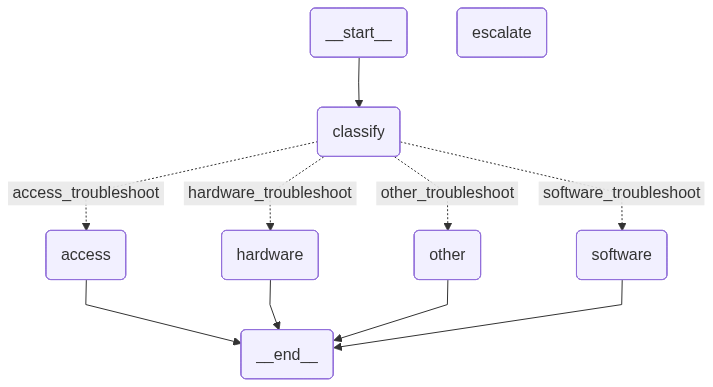

In [51]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
state: HelpdeskState = {
    "issue_description": "My laptop key is broken",
    #"issue_description": "Word application is not opening",
    #"issue_description": "I am not able to login in my system",
    #"issue_description": "I don't know what is hapenning with my PC",
    "attempt_count": 0,
    "steps": [],
    "conversation_history": []
}

final = graph.invoke(state)

print("FINAL STATE:")
print(final)

FINAL STATE:
{'issue_description': 'My laptop key is broken', 'ticket_category': 'Hardware', 'attempt_count': 0, 'resolved': True, 'status': 'resolved', 'steps': ['Classified as: Hardware', 'Classified as: Hardware'], 'conversation_history': []}
